In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img 
import geopandas as gpd
from shapely.geometry import Point
from scipy import spatial, interpolate
import warnings
warnings.filterwarnings("ignore")

In [2]:
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_nation_20m.zip"
us = gpd.read_file(url).explode()
us = us.loc[us.geometry.apply(lambda x: x.exterior.bounds[2])<-60]

In [3]:
df_covariates = pd.read_csv('./data/covariate0605.csv')
df_pm25 = pd.read_csv('./data/pm25_0605.csv')
df_pm25 = df_pm25.loc[df_pm25.Latitude < 50]

x_min,y_min,x_max,y_max = np.array([np.min(df_covariates['long']), np.min(df_covariates['lat']),
    np.max(df_covariates['long']), np.max(df_covariates['lat'])])
arr1 = np.mgrid[x_min:x_max:101j, y_min:y_max:101j]

# extract the x and y coordinates as flat arrays
arr1x = np.ravel(arr1[0])
arr1y = np.ravel(arr1[1])
# using the X and Y columns, build a dataframe, then the geodataframe
df = pd.DataFrame({'X':arr1x, 'Y':arr1y})
df['coords'] = list(zip(df['X'], df['Y']))
df['coords'] = df['coords'].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.X, y=df.Y),crs = us.crs)
inUS = gdf['geometry'].apply(lambda s: s.within(us.geometry.unary_union))

In [4]:
lonlat_pm25=df_pm25.values[:,[1,2]]gdf1
near = df_covariates.values[:,[1,2]]
tree = spatial.KDTree(list(zip(near[:,0].ravel(), near[:,1].ravel())))
idx = tree.query(lonlat_pm25)[1]
df_pm25_mean = df_pm25.assign(neighbor = idx).groupby('neighbor')['PM25'].mean()
idx_new = df_pm25_mean.index.values
pm25 = df_pm25_mean.values
z = pm25[:,None]

lon = df_covariates.values[:,1]
lat = df_covariates.values[:,2]

f = interpolate.Rbf(lon[idx_new], lat[idx_new], z, function = 'inverse')
x_test = gdf.loc[inUS,:].X
y_test = gdf.loc[inUS,:].Y
z_test = f(x_test, y_test)

<Figure size 640x480 with 0 Axes>

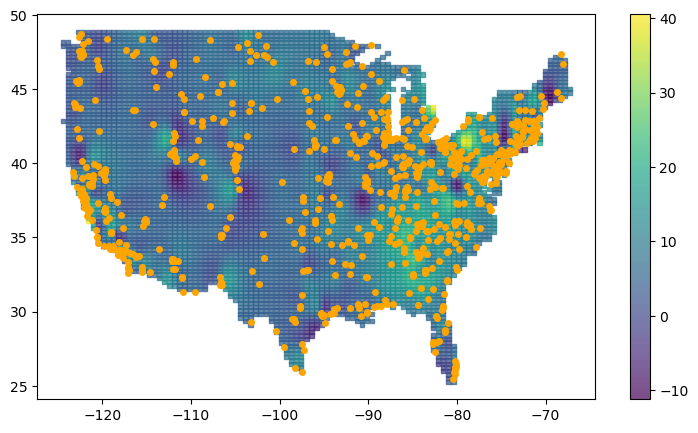

In [5]:
plt.clf()
fig, ax = plt.subplots(figsize=(9, 5))
c = ax.scatter(x = x_test, y = y_test, s = 10, c = z_test, marker = 's', alpha = 0.7)
ax.plot(np.array(df_pm25['Longitude']), np.array(df_pm25['Latitude']), 'o', c = 'orange', markersize = 4)
ax.set_title('')
fig.colorbar(c, ax=ax)
plt.show()

In [9]:
lon = df_covariates.values[:,1]
lat = df_covariates.values[:,2]
covariates = df_covariates.values[:,3:]
normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
normalized_lat = (lat-min(lat))/(max(lat)-min(lat))
normalized_x_test = (x_test-min(lon))/(max(lon)-min(lon))
normalized_y_test = (y_test-min(lat))/(max(lat)-min(lat))

s_obs = np.vstack((normalized_lon[idx_new],normalized_lat[idx_new])).T
X = covariates[idx_new,:]
normalized_X = X
for i in range(X.shape[1]):
    normalized_X[:,i] = (X[:,i]-min(X[:,i]))/(max(X[:,i])-min(X[:,i]))

X = normalized_X
Y = z.reshape(-1)
coord = s_obs
#columns = ['precipitation', 'temperature', 'air pressure', 'relative humidity', 'U-wind', 'V-wind',
#           'PM 2.5', 'longitude', 'latitude']
#df = pd.DataFrame(data=data, index=range(data.shape[0]), columns=columns)
#df.to_csv('./data/Normalized_PM2.5_20190605.csv')

In [10]:
data_PM25 = pd.read_csv("./data/Normalized_PM2.5_20190605.csv")
data_PM25

,Unnamed: 0,precipitation,temperature,air pressure,relative humidity,U-wind,V-wind,PM 2.5,longitude,latitude
0,0,0.008044,0.362296,0.887664,0.774197,0.868530,0.781498,5.020834,0.980311,0.906268
1,1,0.005516,0.355305,0.882153,0.751742,0.864206,0.770715,3.837500,0.983093,0.889762
2,2,0.000000,0.335323,0.928359,0.714189,0.697080,0.813224,2.041666,0.974238,0.814722
3,3,0.000000,0.338579,0.954218,0.690767,0.625266,0.868161,3.669444,0.976951,0.798275
4,4,0.002528,0.293827,0.893599,0.685830,0.688808,0.842395,1.020833,0.945193,0.800337
...,...,...,...,...,...,...,...,...,...,...
600,600,0.393932,0.901079,0.972022,0.910279,0.642436,0.469410,5.168750,0.469337,0.101640
601,601,0.000689,0.810329,0.897414,0.539392,0.553265,0.464926,6.041666,0.436702,0.098054
602,602,0.294415,0.882501,0.972022,0.822590,0.642248,0.469353,8.704166,0.468665,0.090378
603,603,0.011492,0.811830,0.965240,0.719028,0.676463,0.512429,8.725000,0.460179,0.035680


In [11]:
X = torch.from_numpy(data_PM25[['precipitation', 'temperature', 'air pressure', 'relative humidity', 'U-wind', 'V-wind']].to_numpy()).float()
Y = torch.from_numpy(data_PM25[['PM 2.5']].to_numpy().reshape(-1)).float()
coord = torch.from_numpy(data_PM25[['longitude', 'latitude']].to_numpy()).float()

p = X.shape[1]

n = X.shape[0]
nn = 20
batch_size = 50

data = geospaNN.make_graph(X, Y, coord, nn)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size = 20, 
                                                   test_proportion = 0.5)

In [12]:
start_time = time.time()
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
nn_model = geospaNN.nn_train(mlp_nn, lr =  0.01, min_delta = 0.001)
training_log = nn_model.train(data_train, data_val, data_test)

Epoch 00049: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00078: reducing learning rate of group 0 to 2.5000e-03.
INFO: Early stopping
End at epoch81


In [13]:
theta0 = geospaNN.theta_update(torch.tensor([1, 1.5, 0.01]), mlp_nn(data_train.x).squeeze() - data_train.y, data_train.pos, neighbor_size = 20)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
)
model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
nngls_model = geospaNN.nngls_train(model, lr =  0.01, min_delta = 0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init = 20, Update_step = 10)
end_time = time.time()

Theta updated from
[1.   1.5  0.01]
Theta updated from
[ 9.27663776 12.73437123  0.20920395]
to
[11.02356175  8.51068655  0.15839183]
Epoch 00021: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping
End at epoch24


In [14]:
print(f"\rRunning time: {end_time - start_time} seconds")

Running time: 6.861386060714722 seconds


In [18]:
def predict(self, data_train, data_test, CI = False, **kwargs):
    with torch.no_grad():
        w_train = data_train.y - self.estimate(data_train.x)
        if CI:
            w_test, w_u, w_l = geospaNN.krig_pred(w_train, data_train.pos, data_test.pos, self.theta, **kwargs)
            estimation_test = self.estimate(data_test.x)
            return [estimation_test + w_test, estimation_test + w_u, estimation_test + w_l]
        else:
            w_test, _, _ = geospaNN.krig_pred(w_train, data_train.pos, data_test.pos, self.theta, **kwargs)
            estimation_test = self.estimate(data_test.x)
            return estimation_test + w_test

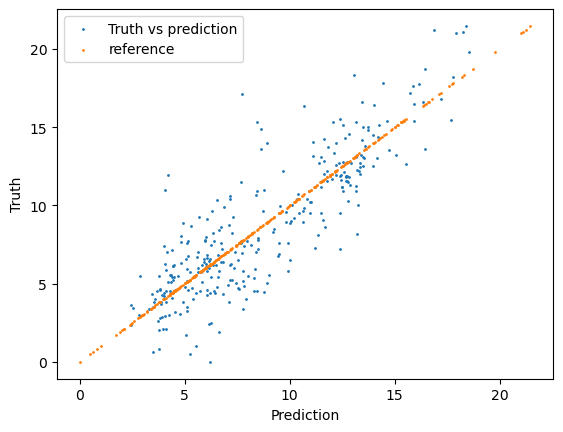

In [21]:
[test_predict, test_U, test_L] = model.predict(data_train, data_test, CI = True)
plt.clf()
plt.scatter(test_predict.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'Truth vs prediction')
plt.scatter(data_test.y.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'reference')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.legend()
plt.show()

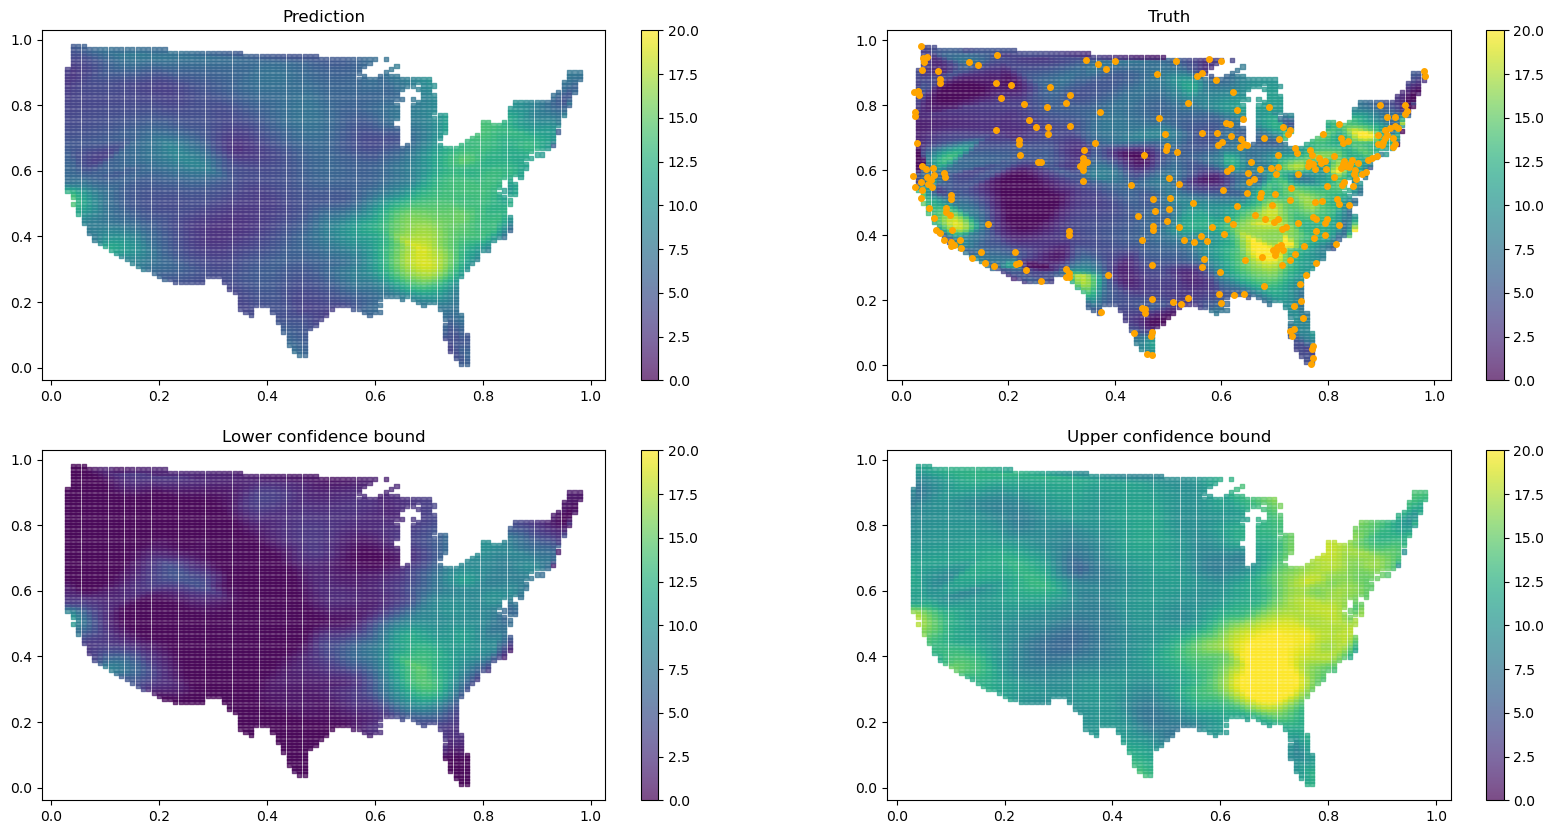

In [43]:
f_pred = interpolate.CloughTocher2DInterpolator(list(zip(data_test.pos.detach().numpy()[:,0], 
                                                data_test.pos.detach().numpy()[:,1])),
                                                test_predict.detach().numpy())
f_U = interpolate.CloughTocher2DInterpolator(list(zip(data_test.pos.detach().numpy()[:,0], 
                                                data_test.pos.detach().numpy()[:,1])),
                                                test_U.detach().numpy())
f_L = interpolate.CloughTocher2DInterpolator(list(zip(data_test.pos.detach().numpy()[:,0], 
                                                data_test.pos.detach().numpy()[:,1])),
                                                test_L.detach().numpy())
f_true = interpolate.CloughTocher2DInterpolator(list(zip(data_test.pos.detach().numpy()[:,0], 
                                                data_test.pos.detach().numpy()[:,1])),
                                                data_test.y.detach().numpy())


titles = np.array([['Prediction', 'Truth'], ['Lower confidence bound', 'Upper confidence bound']])
f_vec = np.array([[f_pred, f_true], [f_L, f_U]])

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i in range(2):
    for j in range(2):
        im = ax[i,j].scatter(x = normalized_x_test, y = normalized_y_test, s = 9, 
                             c = f_vec[i,j](normalized_x_test, normalized_y_test), marker = 's', alpha = 0.7, 
                             vmin=0, vmax=20)
        ax[i,j].title.set_text(titles[i,j])
        fig.colorbar(im)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
ax[0,1].plot(data_test.pos.detach().numpy()[:,0], 
           data_test.pos.detach().numpy()[:,1], 'o', c = 'orange', markersize = 4)
plt.show()